# Laboratory #3_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np

from skimage.feature import ORB
from skimage.color import rgb2gray
from skimage.io import imread
from scipy.cluster.vq import vq
from matplotlib import pyplot as plt

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [18]:
# Path from your drive
dataset_path = r'/content/drive/MyDrive/Caltech_101_subset'

In [19]:
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

*   Create a list of file and the corresponding labels

In [20]:
import glob
data = []
for categorie in ['butterfly', 'kangaroo', 'dalmatian']:
  data += [[rgb2gray(imread(im)), categorie] for im in glob.glob(dataset_path + '/' + categorie + '/*.jpg')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  after removing the cwd from sys.path.


In [21]:
print('Total number of images:', len(data))

Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [22]:
import random

# Split the data into classes
butterfly_data = []
kangaroo_data = []
dalmatian_data = []
for im in data:
  if (im[1] == 'butterfly'): butterfly_data.append(im)
  elif (im[1] == 'kangaroo'): kangaroo_data.append(im)
  elif (im[1] == 'dalmatian'): dalmatian_data.append(im)

# Shufffle the data to increase randomness
random.shuffle(butterfly_data)
random.shuffle(kangaroo_data)
random.shuffle(dalmatian_data)

# Split the data into train and test
def data_splitter(data_sample):
  limit = round(len(data_sample)*0.9)
  x_train, x_test = data_sample[:limit], data_sample[limit:]
  return x_train, x_test

x_train = []
x_test = []
for data_sample in (butterfly_data, kangaroo_data, dalmatian_data):
  x_train_prov, x_test_prov = data_splitter(data_sample)
  x_train = x_train + x_train_prov
  x_test = x_test + x_test_prov

In [23]:
print('Train set:', len(x_train))
print('Test set:', len(x_test))

Train set: 219
Test set: 25


*   How do you select the train/test split?

**Solution**

*   In order to select the train/test split, it is essential to consider the split size, the class representation and the randomness.

    1. **Split size:** these values are pre-defined in the assignment (train - 90% and test - 10%);

    2. **Classes representation:** It is secured that all the classes are represented in the training and testing set. So, in each category of data (butterfly, kangaroo and dalmatian), it is selected 90% to the training data and 10% to the test data.

    3. **Randomness:** To include randomness in the data, the function shuffle is used.
    Note that in different executions the accuracy results might vary depending on the shuffle.

## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 64 keypoints.


In [24]:
# Creating the ORB detector
ORB_detector = ORB(n_keypoints=64)

*   Extract ORB descriptors from all the images in the train set.


In [25]:
# Get the descriptors
def get_descriptors(x, detector):
  # List of descriptors
  x_descriptors = []
  # Extract ORB descriptors
  for im in x:
    detector.detect_and_extract(im[0])
    x_descriptors.append(detector.descriptors)
  return x_descriptors

# Get the descriptors from the train set
x_train_descriptors = get_descriptors(x_train, ORB_detector)

*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [26]:
# Size
print('Total size of the feature descriptors:', len(x_train_descriptors))

Total size of the feature descriptors: 219


**Solution**

*   In ORB, the descriptors are obtained based on the key points defined previously. Firstly, the key points are utilised to identify key regions of the image. Usually, a suitable key point is one that is invariant to varying lighting conditions, angle, scale, and background.

    Based on that, descriptors are created in order to describe these key points. So, it is obtained as many features per image as the key points defined. Relatively to the dimensions, mainly, each descriptor uses the intensity centroid as a measure of the orientation. For the "descriptors" variable, the rows represent the number of key points and the columns are the descriptor size.

## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [27]:
from sklearn.cluster import MiniBatchKMeans

# Reshape the descriptors of each image
def reshaper(x_descriptors):
  x_descriptors_reshape = []
  for im in x_descriptors:
    feat = []
    for desc in im:
      feat.extend(desc)
    x_descriptors_reshape.append(feat)
  return x_descriptors_reshape

# Get the reshaped descriptors
x_train_descriptors_reshape = reshaper(x_train_descriptors)
# Cluster the descriptors
kmeans = MiniBatchKMeans(n_clusters=ncl, random_state=1).fit(x_train_descriptors_reshape)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

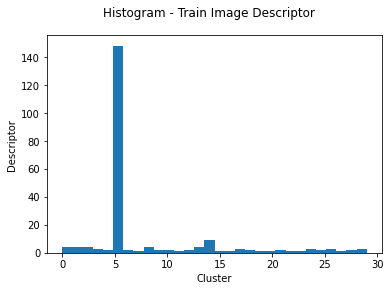

In [28]:
plt.hist(kmeans.labels_, bins = 30)
plt.suptitle('Histogram - Train Image Descriptor')
plt.xlabel('Cluster')
plt.ylabel('Descriptor')
plt.show()


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

*   Use GridSearchCV to find the optimal value of C and Gamma.

In [30]:
# Define C and Gamma
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]} 
GS_SVC = GridSearchCV(SVC(), param_grid)

# Get y data
def get_y(x):
  # Set y_train data
  y = []
  for label in x:  
    y += [label[1]]
  return y

y_train = get_y(x_train)

# Fitting the model for grid search
GS_SVC.fit(x_train_descriptors_reshape, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]})

# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


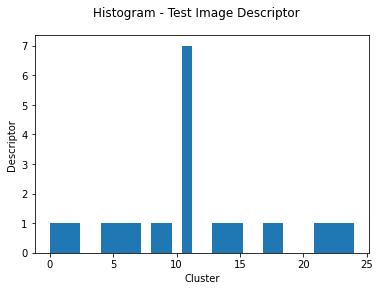

Prediction: ['butterfly' 'butterfly' 'butterfly' 'kangaroo' 'butterfly' 'butterfly'
 'butterfly' 'butterfly' 'kangaroo' 'kangaroo' 'kangaroo' 'butterfly'
 'butterfly' 'kangaroo' 'butterfly' 'kangaroo' 'kangaroo' 'kangaroo'
 'kangaroo' 'kangaroo' 'kangaroo' 'dalmatian' 'dalmatian' 'dalmatian'
 'dalmatian']


In [31]:
# List of descriptors
x_test_descriptors = get_descriptors(x_test, ORB_detector)

# Reshape test data
x_test_descriptors_reshape = reshaper(x_test_descriptors)

# Histogram
kmeans = MiniBatchKMeans(n_clusters=25).fit(x_test_descriptors_reshape)
plt.hist(kmeans.labels_, bins = 30)
plt.suptitle('Histogram - Test Image Descriptor')
plt.xlabel('Cluster')
plt.ylabel('Descriptor')
plt.show()

# Prediction
y_pred = GS_SVC.predict(x_test_descriptors_reshape)
print('Prediction:', y_pred)

*   Calculate the accuracy score for the classification model

In [32]:
# Set y_train data
y_test = get_y(x_test)
print(y_pred)
# Accuracy
GS_SVC.score(x_test_descriptors_reshape, y_test)

['butterfly' 'butterfly' 'butterfly' 'kangaroo' 'butterfly' 'butterfly'
 'butterfly' 'butterfly' 'kangaroo' 'kangaroo' 'kangaroo' 'butterfly'
 'butterfly' 'kangaroo' 'butterfly' 'kangaroo' 'kangaroo' 'kangaroo'
 'kangaroo' 'kangaroo' 'kangaroo' 'dalmatian' 'dalmatian' 'dalmatian'
 'dalmatian']


0.68

*   Generate the confusion matrix for the classification model

In [33]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix
confusion_matrix(y_test, y_pred, labels=['butterfly', 'kangaroo', 'dalmatian'])

array([[7, 2, 0],
       [3, 6, 0],
       [0, 3, 4]])

*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**

*   Clustering is used to create a codebook, in order to compress the descriptors into a set of visual words. Without clustering, the number of features would be extremely large in the presence of several distinct images. It is more suitable to group similar descriptors into groups and uses centroids as visual words. 


*   To do the clustering there are several different unsupervised methods such as:

    1. K-means++
    2. Bisecting k-means
    3. Fuzzy C-means
    4. k-harmonic means

    Since the clustering method doesn't know which points that are most relevant, it is also possible to add a step that sorts the words by their descriptive quality and reduces them to so-called Descriptive Visual Words.

# Increased Feature Dimensions

*   Repeat the classification using features of 256 ORB keypoints.

In [34]:
# Creating the ORB detector
ORB_detector = ORB(n_keypoints=256)

## TRAIN
# Get the descriptors from the train set
x_train_descriptors = get_descriptors(x_train, ORB_detector)
# Get the reshaped descriptors for the training set
x_train_descriptors_reshape = reshaper(x_train_descriptors)

# Train the model
# Define C and Gamma
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]} 
GS_SVC = GridSearchCV(SVC(), param_grid)
# Fitting the model for grid search
GS_SVC.fit(x_train_descriptors_reshape, y_train)

## TEST
# Get the descriptors from the test set
x_test_descriptors = get_descriptors(x_test, ORB_detector)
# Get the reshaped descriptors for the test set
x_test_descriptors_reshape = reshaper(x_test_descriptors)

# Prediction
y_pred = GS_SVC.predict(x_test_descriptors_reshape)

# Accuracy
print('Accuracy: ', GS_SVC.score(x_test_descriptors_reshape, y_test))

# Confusion Matrix
confusion_matrix(y_test, y_pred, labels=['butterfly', 'kangaroo', 'dalmatian'])

Accuracy:  0.36


array([[8, 1, 0],
       [8, 1, 0],
       [5, 2, 0]])

*   What is the difference in classifier performance between using 64 keypoints and 256 keypoints?

**Solution**

*   By increasing the number of key points, it is verified a dramatic reduction in the accuracy obtained. Quantitatively, the accuracy went from 68% to 36%, a discrepancy of 32%.

    According to the confusion matrices, it is observed that a considerable majority of the images are classified as butterfly. Furthermore, no image is classified as dalmatian and only one is correctly addressed as a kangaroo. According to these values, the excess of detail represented by the descriptors does not constitute useful information for the classification algorithm. In this case, it loses, almost totally, the capacity to identify kangaroo or dalmatian.

*   Will further adding more keypoints increase the performance of the algorithm?

**Solution**

*   According to the previous analysis, the increment in the number of features does not necessarily increase or decrease the accuracy of a classification algorithm. The evolution of the accuracy depends on the number of key points considered priorly.

    For example, from 10 to 64 (1st exercise) key points the accuracy increases, because for the image size considered, only 10 descriptors are not sufficient for a further algorithm successfully label the test set. So, with 64 key points, the information of the image is more detailed, which benefits the algorithm.
    
    On the contrary, increasing the key points from 64 to 256 decreases the accuracy. This is due to the fact that with 256 the image description is over-detailed, and a considerable amount of this information is not useful. Consequentially, it is inserted in the classification algorithm irrelevant information that is not characteristic of that label. In fact, it is just noise. Therefore, the algorithm performs worse than in the first case.

    Overall, it is intended that the descriptors represent the useful information of image related to the correspondent label. For instance, if it is pretended to identify a kangaroo, it is more suitable to have descriptors related to key points of the kangaroo in the image, than of the background.

    As a final note, in order to utilize more key points, a descriptive reduction step should be added to the clustering. This way, it is possible to select the most informative ones for the classification process.


---

## **End of P3_2: Image Classification using Bag of Visual Words**
Deadline for P3_2 submission in CampusVirtual is: **Thursday, the 17th of November, 2022**